## Steps
1. Load data from json File
2. Split data into train test split
3. create neural net using using tensorflow and keras
4. Train the network

In [1]:
import json
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import dill

In [2]:
#load the python notebook state
#dill.load_session('model_env.db')

## Loading the Data

In [3]:
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
    
    x = np.array(data['mfcc'])
    y = np.array(data['labels'])
    num_segments = data['num_segments']
    mapping = data['mapping']
    file_origin = data['file_origin']
    
    
    return x, y, num_segments, mapping, file_origin

In [4]:
x, y, num_segments, mapping, file_origin = load_data("data.json")

In [5]:
len(x)

79940

## Helping Functions

In [6]:
def plot_history(history):
    fig, axs = plt.subplots(2, figsize = (15,15))
    
    
    
    #Create accuracy subplot
    
    axs[0].plot(history.history["acc"], label = "train accuracy")
    axs[0].plot(history.history["val_acc"], label = "test accuracy")
    axs[0].set_ylabel("accuracy")
    axs[0].legend(loc = "lower right")
    axs[0].set_title("accuracy eval")
    
    #Create Error subplot
        
    axs[1].plot(history.history["loss"], label = "train error")
    axs[1].plot(history.history["val_loss"], label = "test error")
    axs[1].set_ylabel("error")
    axs[1].set_xlabel("epochs")
    axs[1].legend(loc = "upper right")
    axs[1].set_title("error eval")
    
    plt.show()

In [7]:
def predict(model, X, y):
    X = X[np.newaxis, :]
    
    # prediction = [[0.2, 0,2, ...]] probabilities
    prediction = model.predict(X)
    
    #extrack index with max value (softmax gives you probabilities)
    predicted_index = np.argmax(prediction, axis = 1)
    
    print("The prediction is: {}, The expected output is: {}".format(mapping[int(predicted_index)], mapping[y]))

In [8]:
#create label encoder for inverse fit
encoder = LabelEncoder()
encoder.classes_ = mapping

## Create Train Test split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

## Creating Model Structure (Simple Dense Model)

In [13]:
#this is going to be a basic neural network consisting of only dense layers
model_1 = keras.Sequential([
    #input layer
    keras.layers.Flatten(input_shape = (x.shape[1], x.shape[2])),
    
    #1st hidden layer
    keras.layers.Dense(512, activation = "relu"),
    
    #2nd hidden layers
    keras.layers.Dense(256, activation = "relu"),
    
    #3rd hidden layers
    keras.layers.Dense(64, activation = "relu"),
    
    keras.layers.Dense(len(mapping), activation = "softmax")
    
])

W0721 09:43:38.128442 139902445979456 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model_1.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1677)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               859136    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
Total params: 1,007,432
Trainable params: 1,007,432
Non-trainable params: 0
_________________________________________________________________


## Training The Model

In [15]:
#this model overfits greatly
history_1 = model_1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 50, batch_size = 128)

Train on 59955 samples, validate on 19985 samples
Epoch 1/50
59955/59955 [==============================] - 4s 65us/sample - loss: 5.6765 - acc: 0.2495 - val_loss: 3.1523 - val_acc: 0.2634
Epoch 2/50
59955/59955 [==============================] - 4s 61us/sample - loss: 2.6388 - acc: 0.2969 - val_loss: 2.4697 - val_acc: 0.2838
Epoch 3/50
59955/59955 [==============================] - 4s 61us/sample - loss: 2.1496 - acc: 0.3295 - val_loss: 2.1661 - val_acc: 0.3316
Epoch 4/50
59955/59955 [==============================] - 4s 62us/sample - loss: 1.9212 - acc: 0.3599 - val_loss: 2.0138 - val_acc: 0.3389
Epoch 5/50
59955/59955 [==============================] - 4s 62us/sample - loss: 1.7906 - acc: 0.3880 - val_loss: 1.9850 - val_acc: 0.3439
Epoch 6/50
59955/59955 [==============================] - 4s 62us/sample - loss: 1.6863 - acc: 0.4136 - val_loss: 2.0439 - val_acc: 0.3467
Epoch 7/50
59955/59955 [==============================] - 4s 61us/sample - loss: 1.6157 - acc: 0.4326 - val_loss: 1.

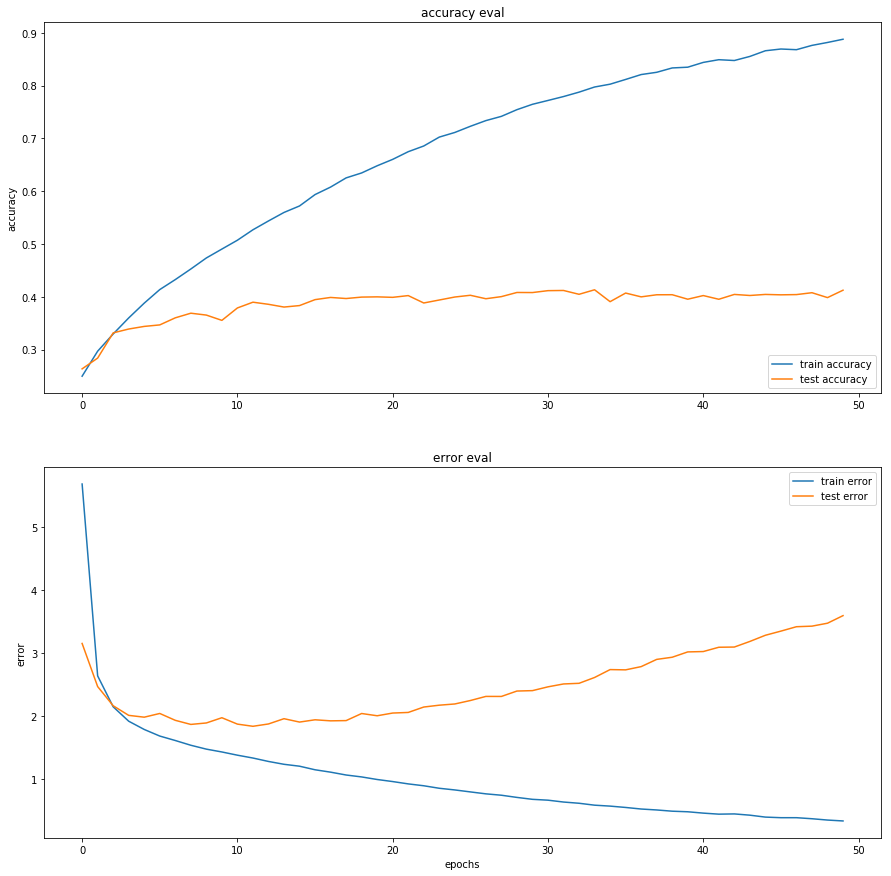

In [16]:
plot_history(history_1)

## Creating Model Structure (Convnet)

In [12]:
x_train_cnn = np.expand_dims(x_train, axis = -1)
x_test_cnn = np.expand_dims(x_test, axis = -1)

In [18]:
x_train_cnn.shape

(59955, 129, 13, 1)

In [19]:
input_shape = x_train_cnn.shape[1:]
model_cnn = keras.Sequential([
    #1st convlayer (input)
    keras.layers.Conv2D(32, (3,3), strides=1,padding = 'same',input_shape = input_shape, activation = 'relu'),
    #Downsizing MaxPool layer
    keras.layers.Conv2D(32, (3,3), strides=1,padding = 'same',activation = 'relu'),
    keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'),
    #normalizes activation
    keras.layers.BatchNormalization(),
                        
    #2nd conv layer
    keras.layers.Conv2D(64, (3,3),strides=1,padding = 'same', activation = 'relu'),
    keras.layers.Conv2D(64, (3,3), strides=1,padding = 'same',activation = 'relu'),
    keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, (3,3),strides=1,padding = 'same', activation = 'relu'),
    keras.layers.Conv2D(128, (3,3), strides=1,padding = 'same',activation = 'relu'),
    keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'),
    keras.layers.BatchNormalization(),


    keras.layers.Dropout(0.3),                    
    #flatten the output to feed to dense output layer
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.3),
                    
    #Dense output layer
    keras.layers.Dense(len(mapping), activation = 'softmax')
])

In [20]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model_cnn.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 129, 13, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 129, 13, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 7, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 65, 7, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 7, 64)         18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 7, 64)         36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 4, 64)        

## Training the Model

In [22]:
history_cnn = model_cnn.fit(x_train_cnn, y_train, validation_data = (x_test_cnn, y_test), batch_size = 128, epochs = 30)

Train on 59955 samples, validate on 19985 samples
Epoch 1/30
59955/59955 [==============================] - 123s 2ms/sample - loss: 1.8114 - acc: 0.3356 - val_loss: 1.6573 - val_acc: 0.4043
Epoch 2/30
59955/59955 [==============================] - 125s 2ms/sample - loss: 1.6445 - acc: 0.4083 - val_loss: 1.5420 - val_acc: 0.4555
Epoch 3/30
59955/59955 [==============================] - 129s 2ms/sample - loss: 1.5580 - acc: 0.4459 - val_loss: 1.4731 - val_acc: 0.4746
Epoch 4/30
59955/59955 [==============================] - 130s 2ms/sample - loss: 1.4907 - acc: 0.4680 - val_loss: 1.4114 - val_acc: 0.4946
Epoch 5/30
59955/59955 [==============================] - 131s 2ms/sample - loss: 1.4315 - acc: 0.4904 - val_loss: 1.3763 - val_acc: 0.5094
Epoch 6/30
59955/59955 [==============================] - 132s 2ms/sample - loss: 1.3783 - acc: 0.5090 - val_loss: 1.3485 - val_acc: 0.5194
Epoch 7/30
59955/59955 [==============================] - 132s 2ms/sample - loss: 1.3287 - acc: 0.5292 - val_l

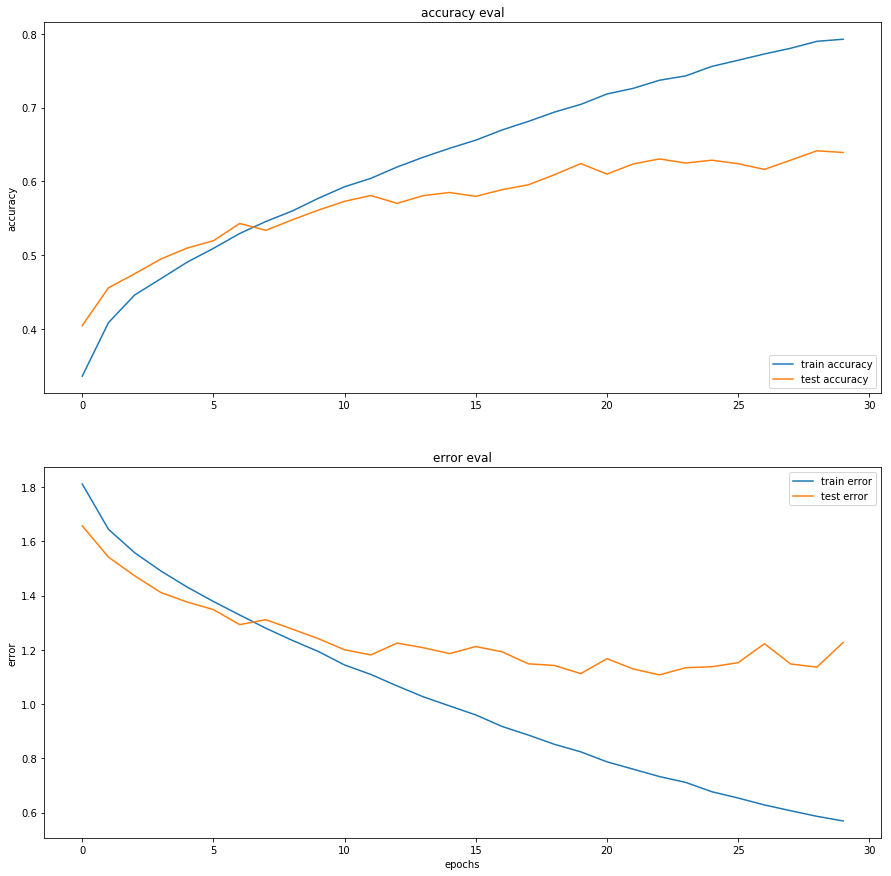

In [23]:
plot_history(history_cnn)

In [ ]:
#Homework
#Presentation
#Data Visualization

In [79]:
test_case = 106
x = x_test_cnn[test_case]
y = y_test[test_case]
predict(model_cnn, x, y)

The prediction is: Instrumental, The expected output is: Instrumental


In [82]:
from sklearn.metrics import confusion_matrix

In [91]:
x.shape

(79940, 129, 13)

In [103]:
prediction_y = model_cnn.predict(np.expand_dims(x, axis = 3))

In [112]:
predictions = np.argmax(prediction_y, axis = -1)

In [113]:
cm = confusion_matrix(y, predictions)

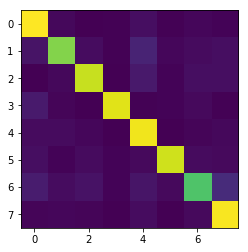

In [114]:
plt.imshow(cm)

## RNN-LSTM Model

In [24]:
input_shape = x.shape[1:]
model_lstm = keras.Sequential()

#2 lstm layers
model_lstm.add(keras.layers.LSTM(64, input_shape = input_shape, return_sequences = True))
model_lstm.add(keras.layers.LSTM(64))

#dense layer
model_lstm.add(keras.layers.Dense(64, activation = "relu"))

#dropout layer
model_lstm.add(keras.layers.Dropout(0.3))

#output layer
model_lstm.add(keras.layers.Dense(len(mapping), activation = 'softmax'))


In [40]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model_lstm.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 129, 64)           19968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 520       
Total params: 57,672
Trainable params: 57,672
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_lstm = model_lstm.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 128, epochs = 30)


W0721 10:53:05.313315 139902445979456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 59955 samples, validate on 19985 samples
Epoch 1/30
59955/59955 [==============================] - 130s 2ms/sample - loss: 1.9550 - acc: 0.2452 - val_loss: 1.8089 - val_acc: 0.3297
Epoch 2/30
59955/59955 [==============================] - 128s 2ms/sample - loss: 1.7964 - acc: 0.3269 - val_loss: 1.7372 - val_acc: 0.3569
Epoch 3/30
59955/59955 [==============================] - 128s 2ms/sample - loss: 1.7436 - acc: 0.3527 - val_loss: 1.6987 - val_acc: 0.3732
Epoch 4/30
59955/59955 [==============================] - 128s 2ms/sample - loss: 1.7057 - acc: 0.3725 - val_loss: 1.6730 - val_acc: 0.3860
Epoch 5/30
59955/59955 [==============================] - 128s 2ms/sample - loss: 1.6771 - acc: 0.3870 - val_loss: 1.6514 - val_acc: 0.3933
Epoch 6/30
59955/59955 [==============================] - 128s 2ms/sample - loss: 1.6560 - acc: 0.3960 - val_loss: 1.6339 - val_acc: 0.4010
Epoch 7/30
59955/59955 [==============================] - 130s 2ms/sample - loss: 1.6346 - acc: 0.4073 - val_l

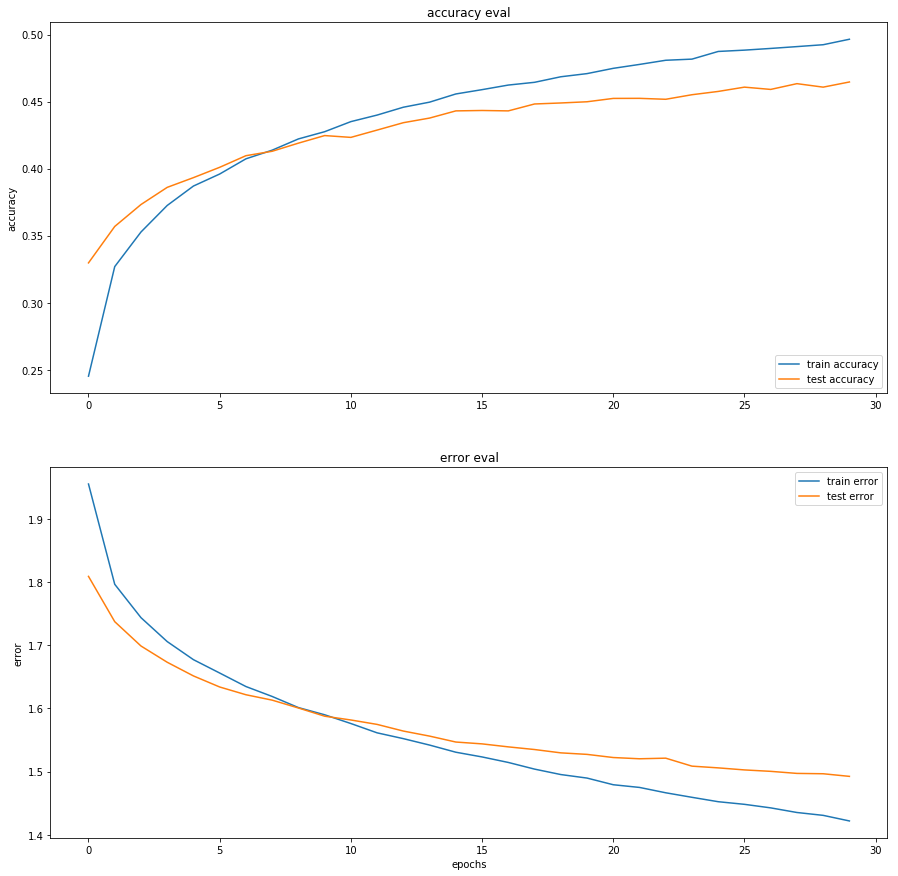

In [27]:
plot_history(history_lstm)

## CNN-LSTM

In [14]:
from tensorflow.keras.layers import TimeDistributed

In [15]:
input_shape = x_train_cnn.shape[1:]
model_cnn_lstm = keras.Sequential()

#CNN Model
model_cnn_lstm.add(TimeDistributed(keras.layers.Conv2D(32, (3,3), strides=1,padding = 'same', input_shape = input_shape, activation = 'relu')))
model_cnn_lstm.add(TimeDistributed(keras.layers.Conv2D(32, (3,3), strides=1,padding = 'same',activation = 'relu')))
model_cnn_lstm.add(TimeDistributed(keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same')))
# model_cnn_lstm.add(TimeDistributed(keras.layers.Flatten()))
                   
#LSTM Model
model_cnn_lstm.add(keras.layers.LSTM(64, activation = 'relu'))
model_cnn_lstm.add(keras.layers.LSTM(64, activation = 'relu'))  
#dense layer
model_cnn_lstm.add(keras.layers.Dense(64, activation = "relu"))

#dropout layer
model_cnn_lstm.add(keras.layers.Dropout(0.3))

#output layer
model_cnn_lstm.add(keras.layers.Dense(len(mapping), activation = 'softmax'))


In [18]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model_cnn_lstm.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model_cnn_lstm.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [47]:
history_cnn_lstm = model_cnn_lstm.fit(x_train_cnn, y_train, validation_data = (x_test_cnn, y_test), batch_size = 128, epochs = 30)

ValueError: input tensor must have rank 4

In [1]:
#Save notebook state
dill.dump_session('model_env.db')

NameError: name 'model_lstm' is not defined